# Vectorizacion de texto

# Funciones de limpieza

In [28]:
# Importo las librerias necesarias
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json
import glob
import re
from pprint import pprint

In [29]:
# Funciones de limpieza de títulos

def remove_stops(text, stops):
    text = re.sub(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+','',text)
    text = re.sub(r'[^\w\s -]','',text)
    text = re.sub(r'-',' ',text)
    text = text.lower()
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    final = "".join([i for i in final if not i.isdigit()])
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

def clean_docs(docs):
    stops = stopwords.words("spanish")
    final = []
    for doc in docs:
        #clean_doc = remove_stops(doc, stops)
        final.append(doc)
    return (final)

# Creo las variables con titulos candidatos y encontrados.

In [177]:
# Creo las variables con titulos candidatos y encontrados.

encontrado = pd.read_csv("titulosEncontrados.csv", sep=',',  encoding='utf-8')
candidato = pd.read_csv("titulosCandidatos.csv", sep=',',  encoding='utf-8')
candidato = candidato.dropna()
encontrado = encontrado.dropna()
titEncontrado = clean_docs(encontrado['titulo'])
titCandidato = clean_docs(candidato['titulo'])

In [181]:
# Creo las variables que contienen los dataframes de titulos candidatos y encontrados.
dfTitCandidato = pd.read_csv('df_titulosCandidatos.csv', sep=',',  encoding='utf-8')
dfTitEncontrado = pd.read_csv('df_titulosEncontrados.csv', sep=',',  encoding='utf-8')

# TF_IDF

In [32]:
stops = stopwords.words("spanish")
# Creo el vectorizador tf-idf de titulos encontrados y transformo titulos candidatos y encontrados
vectorizer = TfidfVectorizer(
                                lowercase=False,
                                use_idf=True,
                                max_features=20000,
                                max_df=0.99,
                                min_df=50,
                                ngram_range = (1,3),
                                stop_words = stops
                            )

vectorizer.fit(titEncontrado)
vectorsCandidatos = vectorizer.transform(titCandidato)
vectorsEncontrado = vectorizer.transform(titEncontrado)
feature_names = vectorizer.get_feature_names_out()

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(vectorsCandidatos, vectorsEncontrado)

In [37]:
# TOPIC MODELING - K-MEANS
true_k = 20

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectorsEncontrado)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

with open ("clusters_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

# CountVectorizer

In [182]:
# Importo las librerias necesarias.
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

'''
Creo el vectorizador - Función: countVectorizer.
Entreno el vectorizador con títulos candidatos a nivel de caracteres.
Creo las matrices de títulos candidatos y títulos encontrados.
'''
coun_vect = CountVectorizer(max_df=0.95,min_df=100,lowercase=True, analyzer="char", ngram_range=(1,3),max_features = 300)
coun_vect.fit(titEncontrado)
count_candidatos = coun_vect.transform(titCandidato)
count_encontrados = coun_vect.transform(titEncontrado)
count_array = count_candidatos.toarray()
dfCountVec = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())
dfCountVec

# Dimensiones: 
# encontrados 5286 rows × 300 columns
# candidatos 10105 rows × 300 columns

,,a,ac,au,c,cl,co,d,e,f,...,usi,ut,uto,v,va,vi,x,xa,xam,z
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
3,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10103,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Distancia cosenoidal

In [186]:
# Calculo de la similitud de vectores - Función: similitud coseno
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(count_candidatos, count_encontrados)

In [184]:
# Filas - Vectores - titulos candidatos
dist[:,0].shape

(10105,)

In [185]:
# Filas: titulos candidatos
# Columnas: titulos encontrados
dist.shape

(10105, 5286)

# BUSQUEDA DE TÍTULOS CANDIDATOS
## DISTANCIA COSENOIDAL

In [191]:
# Calculo la distancia entre títulos candidatos y títulos encontrados. Solo se guarda el valor mayor de similitud.
candidatoList=[]
encotradoList=[]
distancia=[]
for i_cand in range(dist.shape[0]):
    i_enc = numpy.argmax(dist[i_cand])
    candidatoList.append(titCandidato[i_cand])
    encotradoList.append(titEncontrado[i_enc])
    distancia.append(dist[i_cand][i_enc])

# Creo un dataframe de Nuevos títulos encontrados y sus distancias cosenoidales.
dfNuevosCandidatosDistancia = pd.DataFrame({'candidato':candidatoList, 'encontrado': encotradoList, 'distancia': distancia})

# BUSQUEDA DE TÍTULOS CANDIDATOS
## Comparación de palabras

In [187]:
# Funcion para buscar titulos candidatos = titulos encontrados
def buscartitulo(tituloE, tituloC):
    titEncontrados = []
    for titulo in tituloE:
        for candidato in tituloC:
            if titulo == candidato:
                titEncontrados.append(candidato)
    return titEncontrados

    

In [188]:
# Creo los diccionarios de titulos candidatos y titulos encontrados.
encontradosTokens = encontrado.value_counts().head(100)
candidatoToken = candidato.value_counts().head(500)

In [48]:
# Convierte a lista los titulos
def listartitulos(tokens):
    listTit=[]
    for i,j in tokens.items():
        i = remove_stops(str(i),stops)
        listTit.append(i)
    return listTit

In [49]:
# Convierto titulos a listas de titulos.
candidatosList = listartitulos(candidatoToken)
encontradosList = listartitulos(encontradosTokens)

In [189]:
# Creo una variable que contiene los titulos candidatos = titulos encontrados
# Diccionario de titulos candidatos para la busqueda.
candidatosEncontrados = buscartitulo(encontradosList, candidatosList)

# Búsqueda de títulos en los títulos candidatos

In [52]:
# Buscar_candidatos: compara títulos candidatos con el diccionario te títulos candidatos=encontrados
def buscar_candidatos(encontrado, candidato, ide, inicio, fin):
    indiceEncontrados=[]
    for i in range(len(candidato)):
        for e in encontrado:
            if candidato[i] == e:
                indiceEncontrados.append((ide[i],candidato[i], inicio[i], fin[i]))
    return indiceEncontrados

In [53]:
# Lista con los títulos candidatos que son títulos de sección, su índice y ubicación
indicesCandidatos = buscar_candidatos(candidatosEncontrados ,dfTitCandidato.titulo, dfTitCandidato.ide, dfTitCandidato.inicio, dfTitCandidato.fin)

In [190]:
# Creo un dataframe de nuevos titulos encontrados y su ubicacion.
dfUbicacionNuevosEncontrados = pd.DataFrame(indicesCandidatos, columns=['ide', 'titulo', 'inicio', 'fin'])

In [55]:
dfUbicacionNuevosEncontrados.to_csv('df_UbicacionNuevosEncontrados.csv',index=False)
dfUbicacionNuevosEncontrados.to_excel('df_UbicacionNuevosEncontrados.xlsx',index=False)

# PRUEBAS

<AxesSubplot:>

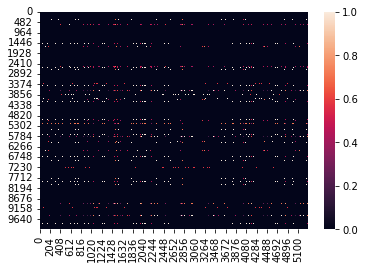

In [123]:
import seaborn as sns
import numpy as np

sns.heatmap(dist)

In [165]:
import numpy
numpy.argmax(dist[0])


864

In [166]:
dist[0][864]

0.9497552120347302

In [167]:
titEncontrado[864]

'antecedentes importancia medico legal'

In [168]:
titCandidato[0]

'antecedentes medicos legales importancia'